# Classification Trees

* 這堂課會用 **scikit-learn** and **Cost Complexity Pruning** 來建立 **Classification Tree**  
* 要使用的資料來自 **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**  裡的 **[Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**  
* 目標是：預測病人是否有 **[heart disease](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)** based on 這個人的性別、年齡、血壓、和各式各樣的 metrics. 
![](tree.png)

* **Classification Trees** 是一個很好解釋的模型，尤其是在你要跟你老闆或user報告，這個預測結果是怎麼來的的時候 (how the decisions are being made)  
* 舉例來說，我預測某個病人有心臟病，且他是位於上圖的最右下角。那我的解釋就是：因為該病人屬於 {ca > 0.5, cp<=3.5, oldpeak > 0.55} 這一組。而根據過去資料，這一組的13個病人中有 10 個病人都有心臟病，所以我預測他有心臟病。
* 這堂課會涵蓋到的主題：  
  - **[Importing Data](#download-the-data)**
  - **[Missing Data](#identify-and-deal-with-missing-data)**
    - Identifying Missing Data
    - Dealing with Missing Data
  - **[Formatting the Data for Decision Trees](#format-the-data)**
    - Splitting data into Dependent and Independent Variables
    - One-Hot-Encoding
  - **[Building a Preliminary Classification Tree](#build-tree)**
  - **[Optimzing the tree with Cost Complexity Pruning](#prune-tree)**
    - Visualizing Alpha
    - Using Cross Validation to find the best value for Alpha
  - **[Building, Drawing, Interpreting and Evaluating the Final Classification Tree](#draw-tree)**

***

## Import the modules

In [1]:
import pandas as pd # to load and manipulate data and for One-Hot Encoding
import numpy as np # to calculate the mean and standard deviation
import matplotlib.pyplot as plt # to draw graphs
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.model_selection import train_test_split # to split data into training and testing sets
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix

from pandas_profiling import ProfileReport

In [2]:
from ipywidgets import FloatProgress

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


----

<a id="download-the-data"></a>
## Import the data

In [17]:
df = pd.read_csv('processed.cleveland.data', 
                 header=None)
## 要自己下載也可以
# df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', 
#                  header=None)

df.columns = ['age', 
              'sex', 
              'cp', 
              'restbp', 
              'chol', 
              'fbs', 
              'restecg', 
              'thalach', 
              'exang', 
              'oldpeak', 
              'slope', 
              'ca', 
              'thal', 
              'hd']

df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## 資料檢查 & 清理

* 從上表看起來，每一欄都是數字，但其實他是把類別型的也用數字呈現了。
* 說明一下各欄位的意義：
    - **age**, **Float**
    - **sex** - **Category**
      - 0 = female
      - 1 = male
    - **cp**, chest pain, 胸痛, **Category**
      - 1 = typical angina
      - 2 = atypical angina
      - 3 = non-anginal pain
      - 4 = asymptomatic
    - **restbp**, resting blood pressure (in mm Hg),靜止血壓, **Float**
    - **chol**, serum cholesterol in mg/dl, 血清膽固醇, **Float**
    - **fbs**, fasting blood sugar, 飯前血糖, **Category**
      - 0 = >=120 mg/dl
      - 1 = <120 mg/dl
    - **restecg**, resting electrocardiographic results, 靜態心電圖結果, **Category**
      - 1 = normal
      - 2 = having ST-T wave abnormality
      - 3 = showing probable or definite left ventricular hypertrophy
    - **thalach**,  maximum heart rate achieved, 最高心跳率, **Float**
    - **exang**, exercise induced angina, 運動造成的心絞痛, **Category**
      - 0 = no
      - 1 = yes
    - **oldpeak**, ST depression induced by exercise relative to rest. 心電圖的ST段波形下沉的程度 -> 心肌梗塞的現象, **Float**
    - **slope**, the slope of the peak exercise ST segment, 心電圖的ST段的斜率, **Category**
      - 1 = upsloping
      - 2 = flat
      - 3 = downsloping
    - **ca**, number of major vessels (0-3) colored by fluoroscopy, 幾條大血管有被螢光劑染色, **Float**
    - **thal**, thalium heart scan, 心肌灌流掃描(thalium是鉈-201，掃描時要注射的放射劑), **Category**
      - 3 = normal (no cold spots)
      - 6 = fixed defect (cold spots during rest and exercise)
      - 7 = reversible defect (when cold spots only appear during exercise)
    - **hd**, diagnosis of heart disease, the predicted attribute 心臟病診斷結果，我們的 y

* 我先將資料類型整理如下：

In [21]:
categorical_columns = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
numerical_columns = ["age", "restbp", "chol", "thalach", "oldpeak", "ca"]

* 來看一下目前的資料 type

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      303 non-null    float64
 1   sex      303 non-null    float64
 2   cp       303 non-null    float64
 3   restbp   303 non-null    float64
 4   chol     303 non-null    float64
 5   fbs      303 non-null    float64
 6   restecg  303 non-null    float64
 7   thalach  303 non-null    float64
 8   exang    303 non-null    float64
 9   oldpeak  303 non-null    float64
 10  slope    303 non-null    float64
 11  ca       303 non-null    object 
 12  thal     303 non-null    object 
 13  hd       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


* 發現蠻怪的，剛剛看表格，全都是數字，所以應該都要被判讀為 float64，但 **ca** and **thal**, 卻呈現是`object`，表示資料裡面有 mixtures of things (例如數字 + 字母)，但，**ca(幾條血管被螢光劑染色)** 和 **thal(心機灌流掃描的結果)** 應該就是數值，所以我們來檢查看看

In [23]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

* 我們發現，**ca** 應該只有 0, 3, 2, 1 這四種值，但多出來 `?` ，可見 `?` 就是個 missing data

In [24]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

* 一樣，都有 `?` 在搗亂

<a id="identify-and-deal-with-missing-data"></a>
### identify & deal with missing data

* 剛剛有檢查到，他的 NA 是標成 `?`. 
* 現在把 `?` 換成 python 看得懂的 NA 的樣子吧：  
  * python中，對文字類型的 NA 叫 None，對數值類型的NA 叫 np.nan; 
  * R 的 is.na() 在 python 叫 isnull()，他會偵測出 None 和 np.nan
  * R 的 !is.na() 在 python 叫 notnull()

In [25]:
df.loc[df.ca == "?", "ca"] = None 
df.loc[df.thal == "?", "thal"] = None
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      303 non-null    float64
 1   sex      303 non-null    float64
 2   cp       303 non-null    float64
 3   restbp   303 non-null    float64
 4   chol     303 non-null    float64
 5   fbs      303 non-null    float64
 6   restecg  303 non-null    float64
 7   thalach  303 non-null    float64
 8   exang    303 non-null    float64
 9   oldpeak  303 non-null    float64
 10  slope    303 non-null    float64
 11  ca       299 non-null    object 
 12  thal     301 non-null    object 
 13  hd       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


* sklearn 的 classification tree 無法處理 missing values，所以我們有兩種處理方法：  
  * 刪除整列
  * 補值

* 因為 missing 的很少，所以這邊直接整列刪除就

In [75]:
df_no_missing = df.dropna()
print("original rows: ", len(df))
print("nonmissing rows: ", len(df_no_missing))

original rows:  303
nonmissing rows:  297


----

In [78]:
cat_cols = ['cp', 'restecg', 'slope', 'thal']
for col in cat_cols:
    df_no_missing.loc[:, col] = df_no_missing[col].astype("object")
df_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      297 non-null    float64
 1   sex      297 non-null    float64
 2   cp       297 non-null    object 
 3   restbp   297 non-null    float64
 4   chol     297 non-null    float64
 5   fbs      297 non-null    float64
 6   restecg  297 non-null    object 
 7   thalach  297 non-null    float64
 8   exang    297 non-null    float64
 9   oldpeak  297 non-null    float64
 10  slope    297 non-null    object 
 11  ca       297 non-null    object 
 12  thal     297 non-null    object 
 13  hd       297 non-null    int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 34.8+ KB


/var/folders/j9/71c8r2vs343cb9329xbww0240000gn/T/ipykernel_81386/3365937875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_missing.loc[:, col] = df_no_missing[col].astype("object")


<a id="format-the-data"></a>
## Format Data Part 1: Y and X form

* 接下來，要把資料做成可以餵進去 sklean 的樣子  


**ALSO NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_no_missing` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_no_missing`, rather than reload the original data and remove the missing values etc.

In [80]:
X = df_no_missing.drop('hd', axis=1).copy() # 用 copy 的方式來做，才不會等等改 X 時， df_nomissing 跟著變
y = df_no_missing['hd'].copy()

In [81]:
y[y>0] = 1

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.014)
clf_dt = clf_dt.fit(X_train, y_train)

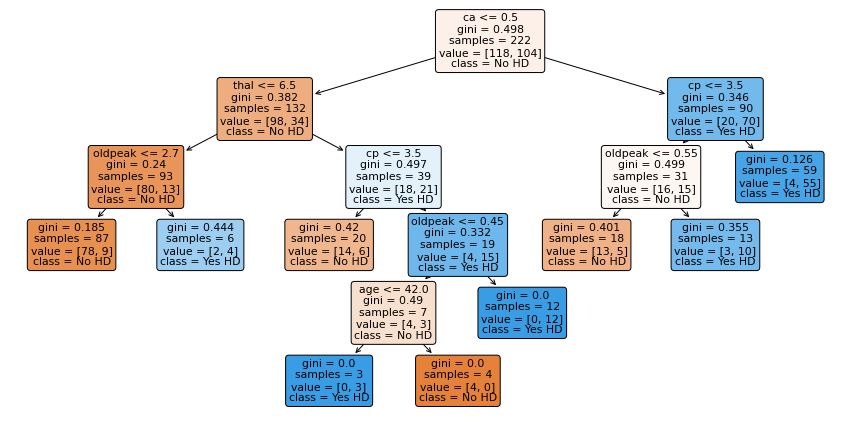

In [83]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X.columns); 

----

<a id="one-hot-encoding"></a>
## Format the Data Part 2: One-Hot Encoding

Now that we have split the dataframe into two pieces, `X`, which contains the data we will use to  predict classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list bellow tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina
  - 2 = atypical angina
  - 3 = non-anginal pain
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)

Now, just to review, let's look at the data types in `X` to remember how python is seeing the data right now.

In [17]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

So, we see that **age**, **restbp**, **chol** and **thalach** are all `float64`, which is good, because we want them to be floating point numbers. All of the other columns, however, need to be inspected to make sure they only contain reasonable values, and some of them need to change. This is because, while **scikit learn Decision Trees** natively support continuous data, like resting blood preasure (**restbp**) and maximum heart rate (**thalach**), they do not natively support categorical data, like chest pain (**cp**), which contains 4 different categories. Thus, in order to use categorical data with **scikit learn Decision Trees**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

At this point you may be wondering, "what's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example: For the **cp** (chest pain) column, we have 4 options:
1. typical angina
2. atypical angina
3. non-anginal pain
4. asymptomatic

If we treated these values, 1, 2, 3 and 4, like continuous data, then we would assume that 4, which means "asymptomatic", is more similar to 3, which means "non-anginal pain", than it is to 1 or 2, which are other types of chest pain. That means the decision tree would be more likely to cluster the patients with 4s and 3s together than the patients with 4s and 1s together. In contrast, if we treat these numbers like categorical data, then we treat each one as a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering patients with 4s with 3s is the same as clustering 4s with 1s, and that approach is more reasonable.

Now let's inspect and, if needed, convert the columns that contain categorical and integer data into the correct datatypes. We'll start with **cp** (chest pain) by inspecting all of its unique values:
<!-- We'll start with the three colunms that should only contain 0s and 1s. **sex**. First, let's make sure it only contains `0` (for **female**) and `1` (for **male**). -->

In [18]:
X['cp'].unique()

array([1., 4., 3., 2.])

So, the good news is that **cp** only contains the values it is supposed to contain, so we will convert it, using **One-Hot Encoding**, into a series of columns that only contains **0s** and **1s**.

<!-- Now we need to deal with **cp** (chest pain), **restecg** (resting electrocardiographic results), **slope** (the slope of the peak exercise ST segment) and **thal** (thalium heart scan).
 -->
**NOTE:** There are many different ways to do **One-Hot Encoding** in Python. Two of the more popular methods are `ColumnTransformer()` (from **scikit-learn**) and `get_dummies()` (from **pandas**), and the both methods have pros and cons. `ColumnTransformer()` has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your **Decision Tree** using a categorical variable **favorite color** that has **red**, **blue** and **green** options, then `ColumnTransformer()` can remember those options and later on when your **Decision Tree** is being used in a production system, if someone says their favorite color is **orange**, then `ColumnTransformer()` can throw an error or handle the situation in some other nice way. The downside of `ColumnTransformer()` is that it turns your data into an array and looses all of the column names, making it harder to verify that your usage of `ColumnTransformer()` worked as you intended it to. In contrast, `get_dummies()` leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behavior that `ColumnTransformer()` has. So, for the sake of learning how **One-Hot Encoding** works, I prefer to use `get_dummies()`. However, once you are comfortable with **One-Hot Encoding**, I encourage you to investigate using `ColumnTransformer()`.

First, before we commit to converting **cp** with **One-Hot Encoding**, let's just see what happens when we convert **cp** without saving the results. This will make it easy to see how `get_dummies()` works.

In [19]:
## For this tutorial, we will use get_dummies() to do One-Hot Encoding,
## but just know that there are other options.
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


As we can see in the printout above, `get_dummies()` puts all of the columns it does not process in the front and it puts **cp** at the end. It also splits **cp** into **4** columns, just like we expected it. **cp_1.0** is `1` for any patient that scored a **1** for chest pain and `0` for all other patients. **cp_2.0** is `1` for any patient that scored **2** for chest pain and `0` for all other patients. **cp_3.0** is `1` for any patient that scored **3** for chest pain and **cp_4.0** is `1` for any patient that scored **4** for chest pain.

Now that we see how `get_dummies()` works, let's use it on the four categorical columns that have more than 2 categories and save the result.

**NOTE:** In a real situation (not a tutorial like this), you should verify all 5 of these columns
only contain the accepted categories. However, for this tutorial, I've already done that for us, so we can skip that step.

In [20]:
X_encoded = pd.get_dummies(X, columns=['cp', 
                                       'restecg', 
                                       'slope', 
                                       'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


## BAM!!!
Now we need to talk about the **3** categorical columns that only contain **0**s and **1**s: **sex**, **fbs** (fasting blood sugar), and **exang** (exercise induced angina). As we can see, **One-Hot Encoding** converts a column with more than **2** categories, like **cp** (chest pain) into multiple columns of **0**s and **1**s. Since **sex**, **fbs**, and **exang** only have **2** categories and only contain **0**s and **1**s to begin with, we do not have to do anything special to them, so we're done formatting the data for the **Classification Tree**.

**NOTE:** In practice we would use `unique()` to verify that they only contain **0**s and **1**s, but to save time...trust me!

Now, one last thing before we build a **Classification Tree**.  `y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease. We can see this with `unique()`:

In [21]:
y.unique()

array([0, 2, 1, 3, 4])

In this tutorial we're only making a tree that does simple classification and only care if someone has heart disease or not, so we need to convert all numbers **> 0** to **1**.

In [22]:
y_not_zero_index = y > 0 # get the index for each non-zero value in y
y[y_not_zero_index] = 1  # set each non-zero value in y to 1
y.unique()               # verify that y only contains 0 and 1.

array([0, 1])

## Double BAM!!!

We have finally finished formatting the data for making a **Classification Tree**, so let's do it!!!

----

<a id="build-tree"></a>
## Build A Preliminary Classification Tree
At long last, the data are correctly formatted for making a **Classification Tree**. Now we simply split the data into **training** and **testing** sets and build the tree.

In [23]:
## split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

## create a decisiont tree and fit it to the training data
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

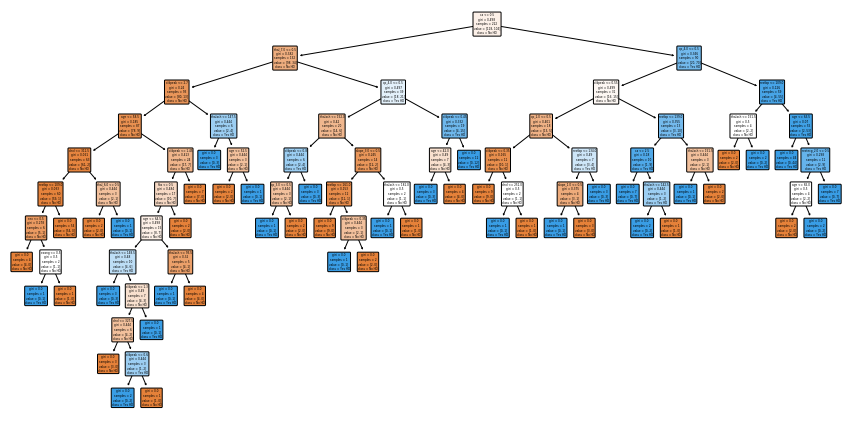

In [24]:
## NOTE: We can plot the tree and it is huge!
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X_encoded.columns); 

OK, we've built a **Classification Tree** for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the tree and drawing a **Confusion Matrix**.

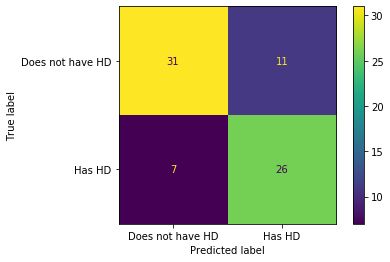

In [25]:
## plot_confusion_matrix() will run the test data down the tree and draw
## a confusion matrix.
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

In the confusion matrix, we see that of the **31 + 11 = 42** people that did not have **Heart Disease**, **31 (74%)** were correctly classified. And of the **7 + 26 = 33** people that have **Heart Disease**, **26 (79%)** were correctly classified. Can we do better? One thing that might be holding this **Classification Tree** back is that it may have **overfit** the training dataset. So let's prune the tree. Pruning, in theory, should solve the overfitting problem and give us better results.

----

<a id="prune-tree"></a>
## Cost Complexity Pruning Part 1: Visualize alpha

**Decision Trees** are notorious for being **overfit** to the **Training Dataset**, and there are a lot of parameters, like `max_depth` and `min_samples`, that are designed to reduce overfitting. However, pruning a tree with **cost complexity pruning** can simplify the whole process of finding a smaller tree that impoves the accuracy with the **Testing Dataset**.

Pruning a decision tree is all about finding the right value for the pruning parameter, `alpha`, which controls how little or how much pruning happens. One way to find the optimal value for `alpha` is to plot the accuracy of the tree as a function of different values.  We'll do this for both the **Training Dataset** and the **Testing Dataset**.

First, let's extract the different values of `alpha` that are available for this tree and build a pruned tree for each value for `alpha`. **NOTE:** We omit the maximum value for alpha with `ccp_alphas = ccp_alphas[:-1]` because it would prune all leaves, leaving us with only a root instead of a tree.

In [48]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value for alpha

In [26]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value for alpha

clf_dts = [] # create an array that we will put decision trees into

## now create one decision tree per value for alpha and store it in the array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

Now let's graph the accuracy of the trees using the **Training Dataset** and the **Testing Dataset** as a function of alpha.

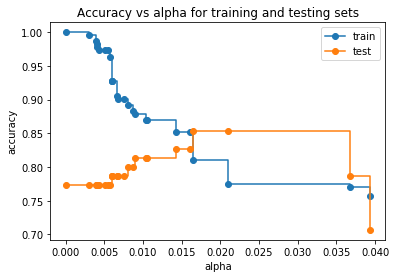

In [27]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In the graph above, we see that the accuracy for the **Testing Dataset** hits its maximum value when `alpha` is about **0.016**. After this value for `alpha`, the accuracy of the **Training Dataset** drops off and that suggests we should set `ccp_alpha=0.016`.

**NOTE:** When we apply **Cost Complexity Pruning** to a **Classification Tree**, values for `alpha` go from 0 to 1, because GINI scores go from 0 to 1. In contrast, values for `alpha` for a **Regression Tree** can be much larger since the sum of squared residuals can, in theory, go from 0 to positive infinity.

Since there are many ways we could have divided the original dataset into **Training** and **Testing** datasets, how do we know we used the best **Training Dataset** and how do we know we used the best **Testing Dataset**? Typically, we answer this question with **10-Fold Cross Validation**. So that's what we're going to do now, and we'll do it with the `cross_val_score()` function.

----

## Cost Complexity Pruning Part 2: Cross Validation For Finding the Best Alpha

The graph we just drew suggested one value for alpha, **0.016**, but another
set of data might suggest another optimal value. 

<!-- **Terminology Alert!!!** Since, ultimately, we have to decide on one value for `alpha`, and
the **Decision Tree** algorithm will not do this for us, `alpha` is called a **Hyperparameter** to differentiate it from the parameters that the **Decision Tree** algorithm can take care of on its own. -->

First, let's demonstrate that different training and testing datasets result in trees with different accuracies when we set `ccp_alpha=0.016`. We will do this by using the `cross_val_score()` function to generate different training and testing datasets and then train and test the tree with those datasets.

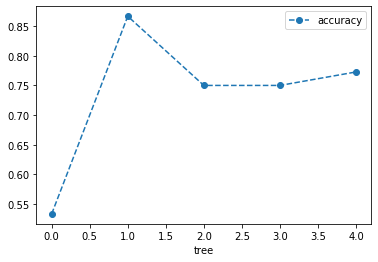

In [28]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016) # create the tree with ccp_alpha=0.016

## now use 5-fold cross validation create 5 different training and testing datasets that
## are then used to train and test the tree.
## NOTE: We use 5-fold because we don't have tons of data...
scores = cross_val_score(clf_dt, X_train, y_train, cv=5) 
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

The graph above shows that using different **Training** and **Testing** data with the same `alpha` resulted in different accuracies, suggesting that `alpha` is sensitive to the datasets. So, instead of picking a single **Training** dataset and single **Testing** dataset, let's use **cross validation** to find the optimal value for `ccp_alpha`.

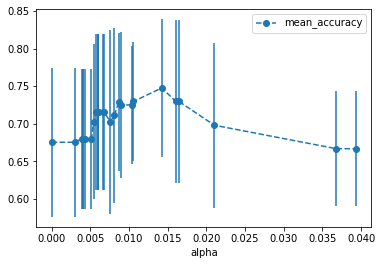

In [29]:
## create an array to store the results of each fold during cross validiation
alpha_loop_values = []

## For each candidate value for alpha, we will run 5-fold cross validation.
## Then we will store the mean and standard deviation of the scores (the accuracy) for each call
## to cross_val_score in alpha_loop_values...
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

## Now we can draw a graph of the means and standard deviations of the scores
## for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', 
                   y='mean_accuracy', 
                   yerr='std', 
                   marker='o', 
                   linestyle='--')

Using cross validation, we can see that, over all, instead of setting `ccp_alpha=0.016`,  we need to set it to something closer to **0.014**. We can find the exact value with:

In [30]:
alpha_results[(alpha_results['alpha'] > 0.014)
              &
              (alpha_results['alpha'] < 0.015)]

,alpha,mean_accuracy,std
20,0.014225,0.747778,0.091395


Now let's store the ideal value for alpha so that we can use it to build the best tree.

In [31]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.014) 
                                & 
                                (alpha_results['alpha'] < 0.015)]['alpha']
ideal_ccp_alpha

20    0.014225
Name: alpha, dtype: float64

**NOTE:** At this point Python thinks that `ideal_ccp_alpha` is a `series`, which is a type of array. We can tell because when we printed `ideal_ccp_alpha` out, we got two bits of stuff. The first one was `20`, which is the index in the series, the second one, `0.014225`, is the value we want. So we can convert this from a series to a float with the following command:

In [32]:
## convert ideal_ccp_alpha from a series to a float
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.014224751066856332

Hooray!!! Now we have the ideal value for `alpha` and we can build, evaluate and draw the final **Classification Tree**.

----

<a id="draw-tree"></a>
## Building, Evaluating, Drawing, and Interpreting the Final Classification Tree

Now that we have the ideal value for `alpha` we can build the final **Classification Tree** by setting `ccp_alpha=ideal_ccp_alpha`:

In [33]:
## Build and train a new decision tree, only this time use the optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=42, 
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train) 

Now let's draw another confusion matrix to see if the pruned tree does better.

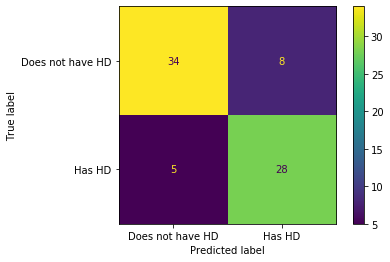

In [34]:
plot_confusion_matrix(clf_dt_pruned, 
                      X_test, 
                      y_test, 
                      display_labels=["Does not have HD", "Has HD"])

Hooray!!! We see that the pruned tree is better at classifying patients than the full sized tree. 

Of the **34 + 8 = 42** people that did not have heart disease, **34 (81%)** were correctly classified. This is an improvement over the full sized tree, which only correctly classified **31 (74%)** of the patients without heart disease. Of the **5 + 28 = 33** people with heart disease, **28 (85%)** were correctly classified. Again, this is an improvement over the full sized tree, which only correctly classified **26 (79%)** of the patients with heart disease. Yay for pruning!

The last thing we are going to do is draw the pruned tree and discuss how to interpret it.

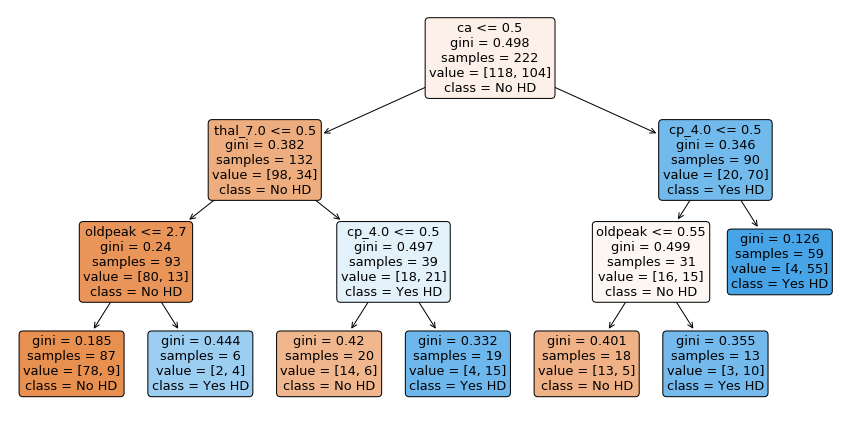

In [35]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X_encoded.columns); 

Now let's discuss how to interpret the tree.
In each node, we have:
- The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use **ca** to split the observations. All
observations with **ca <= 0.5** go to the **left** and all observations with **ca > 0.5** go to the **right**.
- **gini** is the gini index or score for that node
- **samples** tell us how many samples are in that node
- **value** tells us how many samples in the node are in each category. In this example, we have two categories, **No** and **Yes**, referring to whether or not a patient has heart disease. The number of patients with **No** comes first because the categories are in alphabetical order. Thus, in the root, 118 patients have **No** and 104 patients have **Yes**.
- **class** tells us whichever category is represented most in the node. In the root, since 118 people have **No** and only 104 people have **Yes**, class is set to **No**.

The leaves are just like the nodes, except that they do not contain a variable and threshold for splitting the observations.

Lastly, the nodes and leaves are colored by the **class**. In this case **No** is different shades of orange-ish and **Yes** is different shades of blue. The the darker the shade, the lower the **gini** score, and that tells us how much the node or leaf is skewed towards one class.

-----

## In conclusion we...

- **[Imported Data](#download-the-data)**

- **[Identified and Dealt with Missing Data](#identify-and-deal-with-missing-data)**

- **[Formatted the Data for Decision Trees using One-Hot Encoding](#one-hot-encoding)**

- **[Built a Preliminary Decision Tree for Classification](#build-tree)**

- **[Pruned the Decision Tree with Cost Complexity Pruning](#prune-tree)**

- **[Built, Drew, Interpreted and Evaluated the Final Decision Tree](#draw-tree)**

## TRIPLE BAM!!!